In [51]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_validate 
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

### 1. Cleaned Data

#### 1.1. Load data and display setting

In [2]:
diabetic = pd.read_csv('data.csv')

In [3]:
diabetic.shape

(101766, 50)

In [242]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
diabetic_df = diabetic.replace('?', np.nan)

In [6]:
# keep only first encounter for every unique patient
diabetic_df = diabetic_df.sort_values('encounter_id')
diabetic_df.drop_duplicates(subset = ['patient_nbr'], keep = 'first', inplace = True)

In [7]:
diabetic_df.shape

(71518, 50)

#### 1.2 Remove rows and coluns

In [8]:
# remove expired or hospice-bound patients
diabetic_df = diabetic_df[~diabetic_df['discharge_disposition_id'].isin([11,13,14,19,20,21])]

In [9]:
# remove unknown-gender patients
diabetic_df.drop(diabetic_df.loc[diabetic_df.gender=='Unknown/Invalid'].index,inplace=True)

In [10]:
# remove encounter ID, patient NBR, weight, medical specialty, and payer code
diabetic_df.drop(['encounter_id','patient_nbr','weight','medical_specialty','payer_code'],\
                 axis = 1, inplace = True)

In [11]:
# discretize ID columns
diabetic_df['admission_type_id'] = diabetic_df['admission_type_id'].astype('str')
diabetic_df['admission_source_id'] = diabetic_df['admission_source_id'].astype('str')
diabetic_df['discharge_disposition_id'] = diabetic_df['discharge_disposition_id'].astype('str')

In [12]:
diabetic_df.shape

(69970, 45)

### 2. Feature Engineering

#### 2.1 Categorical to Numeric

In [13]:
# binarize target variable: readmitted < 30 days or other
diabetic_df['readmit_30d'] = (diabetic_df['readmitted'] == '<30')

In [14]:
# convert age to a continuous variable
diabetic_df['age_num'] = diabetic_df['age'].replace(
    ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)'],
    [0,10,20,30,40,50,60,70,80,90])

#### 2.2 Diagnose Features

In [15]:
# keep main disease class only
diabetic_df['diag_1'] = diabetic_df['diag_1'].str.split('.', expand = True).drop(1, axis = 1)
diabetic_df['diag_2'] = diabetic_df['diag_2'].str.split('.', expand = True).drop(1, axis = 1)
diabetic_df['diag_3'] = diabetic_df['diag_3'].str.split('.', expand = True).drop(1, axis = 1)

In [16]:
# create a binary variable for each diagnosis in diag_1,2, or 3 that has sample size >500
count_1 = diabetic_df['diag_1'].value_counts()
index_1 = count_1[count_1>=500].index.tolist()

count_2 = diabetic_df['diag_2'].value_counts()
index_2 = count_2[count_2>=500].index.tolist()

count_3 = diabetic_df['diag_3'].value_counts()
index_3 = count_3[count_3>=500].index.tolist()

diagnoses = set(index_1 + index_2 + index_3)

for d in diagnoses:
    diabetic_df[d+'_diag'] = ((diabetic_df['diag_1']==d)|
                              (diabetic_df['diag_2']==d)|
                              (diabetic_df['diag_3']==d))

#### 2.3  Medication Features

In [17]:
# binarize medication features with minority classes > 500 samples: used/not used
for col in ['metformin','repaglinide','glimepiride','glipizide', 'glyburide','pioglitazone',
            'rosiglitazone','insulin']:
    diabetic_df[col+'_used'] = np.where(diabetic_df[col]=='No', False, True)

In [18]:
### 2.4 removing columns <500

#### 2.4 finalizing dataset and dummifying categorical variables

In [19]:
# remove features used to engineer new features
diabetic_final = diabetic_df.drop(['age',
                                   'diag_1','diag_2','diag_3',
                                   'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
                                   'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
                                   'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
                                   'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
                                   'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                                   'readmitted'],
                                 axis = 1)

#### 2.5 Export dataset

In [20]:
# dummify features
diabetic_final = pd.get_dummies(diabetic_final, drop_first = True)
diabetic_final.shape

(69970, 119)

In [21]:
diabetic_final.to_csv('diabetic_model_set.csv',  index = False)

 _____________________________________________________________________________________


In [22]:
data = pd.read_csv('diabetic_model_set.csv')

In [23]:
data

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmit_30d,age_num,560_diag,562_diag,V57_diag,403_diag,820_diag,425_diag,401_diag,599_diag,996_diag,435_diag,V45_diag,518_diag,786_diag,491_diag,434_diag,486_diag,722_diag,440_diag,410_diag,707_diag,577_diag,493_diag,305_diag,433_diag,496_diag,38_diag,250_diag,574_diag,424_diag,682_diag,296_diag,780_diag,427_diag,715_diag,414_diag,285_diag,413_diag,41_diag,585_diag,272_diag,428_diag,411_diag,584_diag,278_diag,276_diag,metformin_used,repaglinide_used,glimepiride_used,glipizide_used,glyburide_used,pioglitazone_used,rosiglitazone_used,insulin_used,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_No,diabetesMed_Yes
0,13,68,2,28,0,0,0,8,False,80,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1,12,33,3,18,0,0,0,8,False,90,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
2,1,51,0,8,0,0,0,5,False,40,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
3,9,47,2,17,0,0,0,9,False,40,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1
4,3,31,6,16,0,0,0,9,False,50,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False

In [24]:
data.drop(['admission_type_id_4',
 'admission_type_id_7',
 'admission_type_id_8',
 'discharge_disposition_id_10',
 'discharge_disposition_id_12',
 'discharge_disposition_id_15',
 'discharge_disposition_id_16',
 'discharge_disposition_id_17',
 'discharge_disposition_id_23',
 'discharge_disposition_id_24',
 'discharge_disposition_id_27',
 'discharge_disposition_id_28',
 'discharge_disposition_id_7',
 'discharge_disposition_id_8',
 'discharge_disposition_id_9',
 'admission_source_id_10',
 'admission_source_id_11',
 'admission_source_id_13',
 'admission_source_id_14',
 'admission_source_id_20',
 'admission_source_id_22',
 'admission_source_id_25',
 'admission_source_id_3',
 'admission_source_id_8',
 'admission_source_id_9'], axis = 1, inplace = True)

In [25]:
diag_variables = ['996_diag', '820_diag',
       '585_diag', '599_diag', '682_diag', '413_diag', '433_diag', '574_diag',
       '296_diag', '411_diag', '584_diag', '486_diag', '496_diag', '440_diag',
       '562_diag', '305_diag', '285_diag', 'V45_diag', '577_diag', '410_diag',
       '414_diag', '560_diag', '780_diag', '278_diag', '722_diag', '38_diag',
       '403_diag', '250_diag', '786_diag', '401_diag', '424_diag', 'V57_diag',
       '276_diag', '435_diag', '427_diag', '715_diag', '518_diag', '272_diag',
       '434_diag', '425_diag', '428_diag', '491_diag', '707_diag', '41_diag',
       '493_diag']

In [26]:
diag_dict = {False : 0, True:1}
for diag_col in diag_variables:
    data[diag_col].replace(diag_dict, inplace = True)

In [27]:
med_variables = ['metformin_used', 'repaglinide_used', 'glimepiride_used',
       'glipizide_used', 'glyburide_used', 'pioglitazone_used',
       'rosiglitazone_used', 'insulin_used']
med_dict = {False : 0, True:1}
for med_col in med_variables:
    data[med_col].replace(med_dict, inplace = True)

In [28]:
readmitted_dict = {True : 1, False: 0}
data.readmit_30d.replace(readmitted_dict, inplace = True)

In [29]:
data

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmit_30d,age_num,560_diag,562_diag,V57_diag,403_diag,820_diag,425_diag,401_diag,599_diag,996_diag,435_diag,V45_diag,518_diag,786_diag,491_diag,434_diag,486_diag,722_diag,440_diag,410_diag,707_diag,577_diag,493_diag,305_diag,433_diag,496_diag,38_diag,250_diag,574_diag,424_diag,682_diag,296_diag,780_diag,427_diag,715_diag,414_diag,285_diag,413_diag,41_diag,585_diag,272_diag,428_diag,411_diag,584_diag,278_diag,276_diag,metformin_used,repaglinide_used,glimepiride_used,glipizide_used,glyburide_used,pioglitazone_used,rosiglitazone_used,insulin_used,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_5,admission_type_id_6,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_25,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,admission_source_id_17,admission_source_id_2,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_No,diabetesMed_Yes
0,13,68,2,28,0,0,0,8,0,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1
1,12,33,3,18,0,0,0,8,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1
2,1,51,0,8,0,0,0,5,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
3,9,47,2,17,0,0,0,9,0,40,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1
4,3,31,6,16,0,0,0,9,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69965,9,50,2,33,0,0,0,9,0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
69966,14,73,6,26,0,1,0,9,0,40,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
69967,2,46,6,17,1,1,1,9,0,60,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1
69968,5,76,1,22,0,1,0,9,0,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1


In [30]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'discharge_disposition_id_5', 'num_lab_procedures',
       '434_diag', '786_diag', '403_diag', 'diabetesMed_Yes',
       'number_emergency', '401_diag', 'discharge_disposition_id_2',
       '428_diag', 'insulin_used', 'num_procedures', '440_diag', '707_diag',
       '272_diag', 'number_outpatient', '820_diag', 'admission_type_id_3',
       '278_diag', 'discharge_disposition_id_6', 'change_No', '414_diag',
       'admission_source_id_7', 'race_Other', 'admission_type_id_6',
       '250_diag', '305_diag', 'metformin_used', 'gender_Male', '722_diag',
       'race_Caucasian', 'glipizide_used', 'admission_type_id_5',
       'A1Cresult_None', '574_diag', 'pioglitazone_used']

## 3. Modeling

### 3.1 Train, Test set split

In [30]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
y_train.value_counts() / len(y_train) * 100

0    91.028298
1     8.971702
Name: readmit_30d, dtype: float64

In [33]:
# ## standard scaler:: 
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

### 3.2 Logistic regression modeling

### 3.2.1 Logistic Regression Model Fitting

In [ ]:
feature_names = X_train.columns

In [34]:
logistic = LogisticRegression(solver='liblinear',
                              penalty='l2',
                              C=0.01,
                              random_state=42,
                             class_weight = 'balanced')

logistic.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', random_state=1,
                   solver='liblinear')

In [35]:
from sklearn.linear_model import LogisticRegression
y_pred = logistic.predict(X_test)

### 3.2.4 Grid Search

In [42]:
from sklearn.model_selection import cross_validate 
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
pipe_logistic = make_pipeline(LogisticRegression(random_state=42))
param_range = [0.01, 0.1, 1.0, 10, 100, 200] 

param_grid = [{'logisticregression__C': param_range}] 

gs = GridSearchCV(estimator=pipe_logistic,
                  param_grid=param_grid, 
                  scoring='roc_auc', 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.6250834404767783
{'logisticregression__C': 200}


In [43]:
# # grid search class weights with decision tree for imbalance classification
# from sklearn.model_selection import RepeatedStratifiedKFold

# balance = [{0:1,1:1}, {0:1,1:2}, {0:1,1:3}]
# param_grid = dict(class_weight=balance)

# grid = GridSearchCV(estimator=LogisticRegression(random_state=42), 
#                     param_grid=param_grid, 
#                     n_jobs=-1, 
#                     cv= 5, 
#                     scoring='roc_auc',)
# grid_result = grid.fit(X_train, y_train)

# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.629976 using {'class_weight': {0: 1, 1: 2}}
0.624659 (0.009222) with: {'class_weight': {0: 1, 1: 1}}
0.629976 (0.007531) with: {'class_weight': {0: 1, 1: 2}}
0.629267 (0.012890) with: {'class_weight': {0: 1, 1: 3}}


In [56]:
from sklearn.metrics import roc_auc_score

In [59]:
roc_auc_score(y_test, y_pred)

0.6059074480006029

In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

### 3.2.2 Confusion Matrix

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],8474,4265
True[1],569,686


In [39]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))
print('accuracy_score: %.3f' % accuracy_score(y_test, y_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

accuracy_score: 0.655
precision_score: 0.139
recall_score: 0.547
f1_score: 0.221


### 3.2.3 precision - recall curve

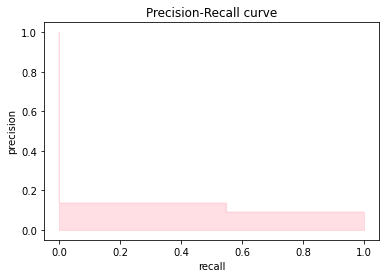

In [41]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### 3.2.5  Logistic Regression — Feature Selection(RFECV)

In [44]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=logistic, step=1, cv= 5, scoring='roc_auc')
rfecv.fit(X_train, y_train)

RFECV(cv=3,
      estimator=LogisticRegression(C=0.01, class_weight='balanced',
                                   random_state=1, solver='liblinear'),
      scoring='roc_auc')

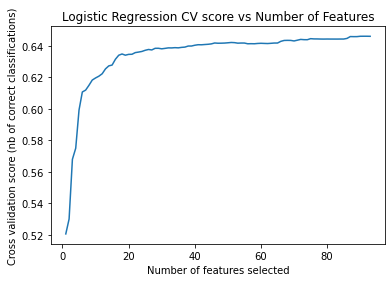

In [45]:
# check  number of features which gives the maximum accuracy
plt.figure()
plt.title('Logistic Regression CV score vs Number of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [48]:
coef = logistic.coef_[0]
for n,v in zip(feature_names, coef):
    print('Feature : %s, Score %.3f' % (n,v))

Feature : time_in_hospital, Score 0.027
Feature : num_lab_procedures, Score 0.002
Feature : num_procedures, Score -0.004
Feature : num_medications, Score -0.001
Feature : number_outpatient, Score -0.010
Feature : number_emergency, Score 0.101
Feature : number_inpatient, Score 0.336
Feature : number_diagnoses, Score 0.025
Feature : age_num, Score 0.005
Feature : 780_diag, Score -0.092
Feature : 305_diag, Score -0.202
Feature : 401_diag, Score -0.155
Feature : 413_diag, Score -0.158
Feature : 584_diag, Score -0.020
Feature : 272_diag, Score -0.245
Feature : 410_diag, Score 0.065
Feature : 682_diag, Score -0.136
Feature : 577_diag, Score 0.127
Feature : 493_diag, Score -0.159
Feature : 518_diag, Score -0.045
Feature : 38_diag, Score -0.090
Feature : 715_diag, Score -0.020
Feature : 560_diag, Score 0.017
Feature : 585_diag, Score -0.006
Feature : 996_diag, Score -0.041
Feature : 786_diag, Score -0.289
Feature : 434_diag, Score 0.280
Feature : 496_diag, Score 0.056
Feature : 820_diag, Score

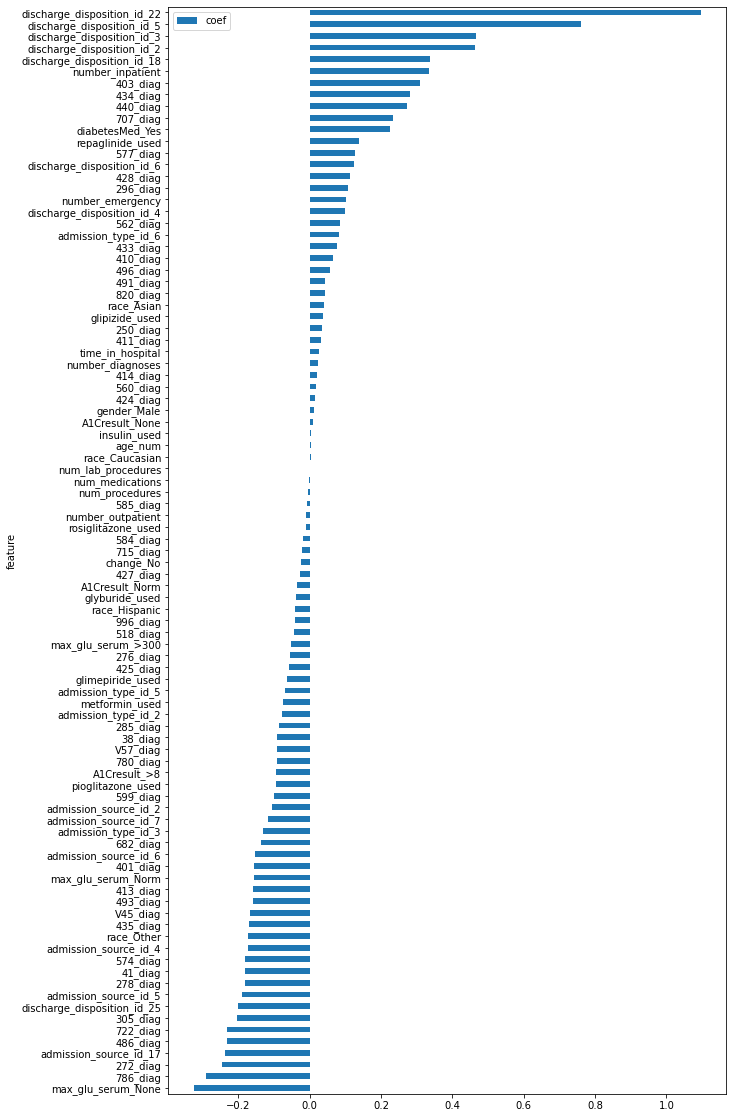

In [51]:
feature_coef = pd.DataFrame({'feature':feature_names,'coef':coef}).sort_values(by='coef')
feature_coef.plot.barh(x= 'feature', y='coef',figsize = (10,20))

### 3.3 Decision Tree modeling

### 3.3.1 Decision Tree model Fitting

In [209]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [210]:
tree = DecisionTreeClassifier(criterion='gini',
                              max_depth= 5, 
                              random_state=42, 
                              class_weight='balanced')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [211]:
y_pred = tree.predict(X_test)

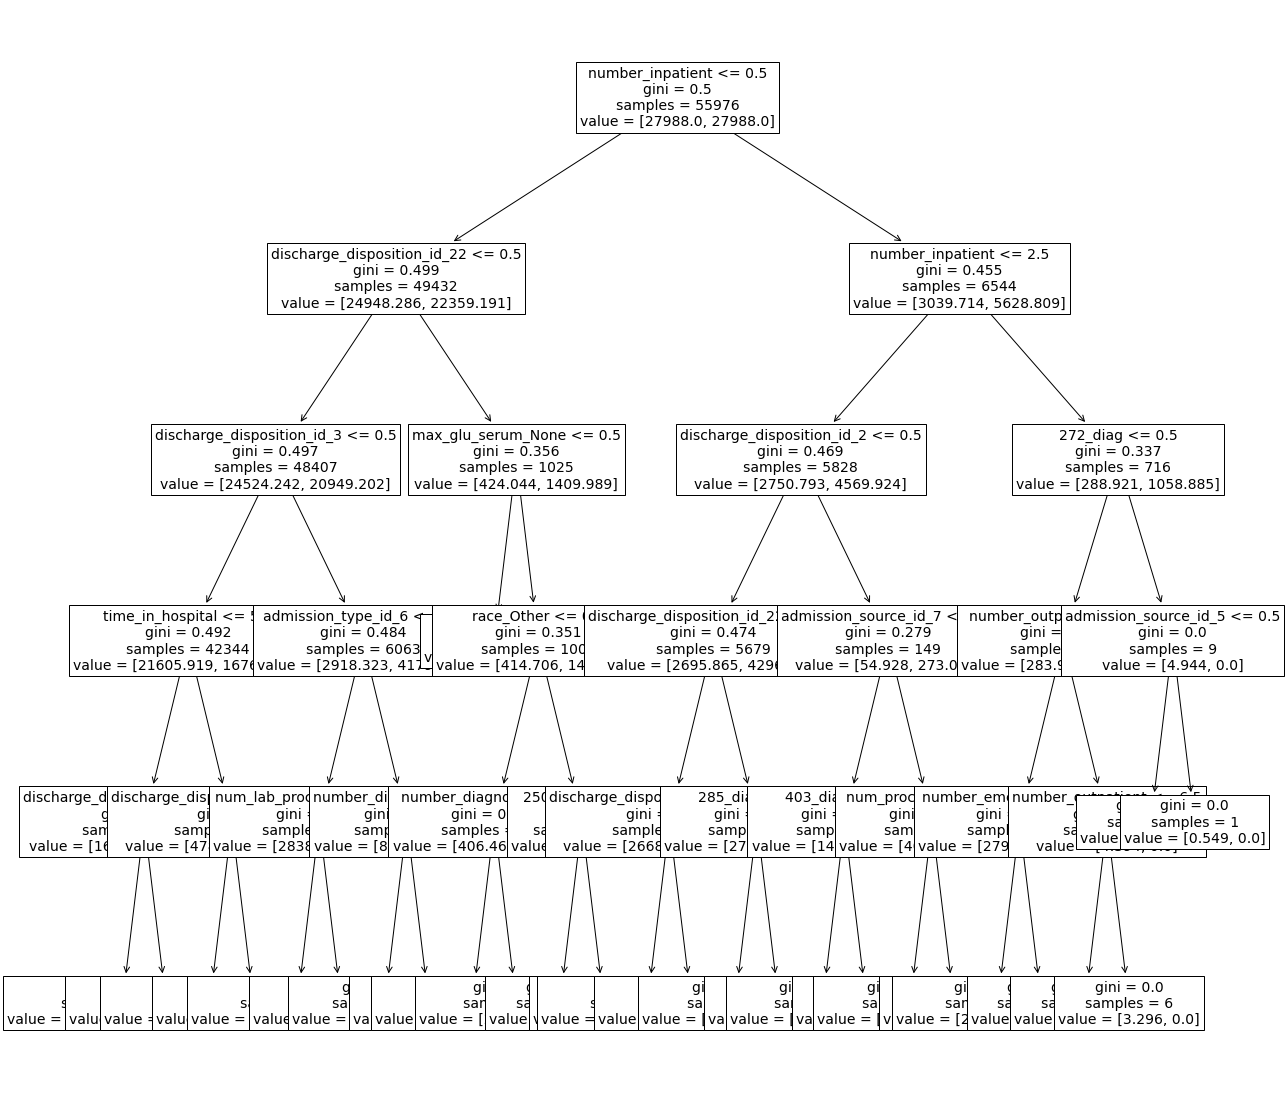

In [212]:
from sklearn.tree import plot_tree
# feature_names=X.column.tolist()
plt.figure(figsize=(20,20))
plot_tree(tree, feature_names=X_train.columns, fontsize=14)
plt.show()

### Grid Search

In [220]:
# grid search class weights with decision tree for imbalance classification
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
 
    
    
# params = {'n_estimators' : [100, 150, 200,250],
#           'max_depth' : [3, 5, 7, 9, 11],
#           'min_samples_split' : [2, 5, 10, 15],
#           'min_samples_leaf' : [1, 2, 5, 10]}

# grid = GridSearchCV(estimator=tree, 
#                     param_grid=params, 
#                     n_jobs=-1, 
#                     cv= 5, 
#                     scoring='roc_auc')
    
    
params = {'max_depth': [3, 5, 7,9],
          'min_samples_split' : [3, 5, 10, 15],
          'min_samples_leaf' : [1, 2, 5, 10]}

grid = GridSearchCV(estimator=tree, 
                    param_grid=params, 
                    n_jobs=1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.621461 using {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 3}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 15}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 3}
0.592907 (0.005284) with: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.592907 (0

In [221]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.6466096062749971
0.6227915404869259


In [222]:
y_train_pred = grid_result.predict(X_train)

In [223]:
y_test_pred = grid_result.predict(X_test)

In [224]:
grid_result.score(X_train, y_train)

0.6466096062749971

In [225]:
grid_result.score(X_test, y_test)

0.6227915404869259

In [89]:
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

0.5195801854499074
0.5079917710428402


In [90]:
# # grid search class weights with decision tree for imbalance classification
# from numpy import mean
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.tree import DecisionTreeClassifier

# # define grid
# balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
# param_grid = dict(class_weight=balance)

# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# # define grid search
# grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, n_jobs=-1, cv= 5, scoring='roc_auc')

# #execute the grid search
# grid_result = grid.fit(X_train, y_train)

# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### 3.3.2  Confusion Matrix

In [226]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9389,3350
True[1],700,555


In [229]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))
print('roc_auc_score:',roc_auc_score(y_test, y_test_pred))

precision_score: 0.142
recall_score: 0.442
f1_score: 0.215
roc_auc_score: 0.5896295499374666


In [93]:
# y_pred_p = tree.predict_proba(X_test)

In [94]:
### 3.3.3 precision recall curve

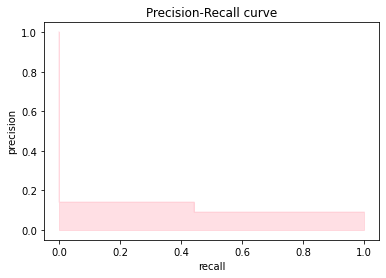

In [230]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

In [231]:
grid.best_estimator_.feature_importances_

array([0.07986249, 0.01722992, 0.01448239, 0.01724773, 0.00261583,
       0.00197317, 0.24658026, 0.02736559, 0.05251769, 0.        ,
       0.        , 0.        , 0.0107407 , 0.00355462, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01246074, 0.        , 0.00036269, 0.00195005, 0.        ,
       0.        , 0.00626517, 0.        , 0.00192077, 0.00768622,
       0.        , 0.00403689, 0.        , 0.00292242, 0.        ,
       0.00052595, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00080356,
       0.        , 0.        , 0.        , 0.01056424, 0.        ,
       0.00471595, 0.        , 0.00444781, 0.        , 0.        ,
       0.01136662, 0.        , 0.03026585, 0.17040041, 0.     

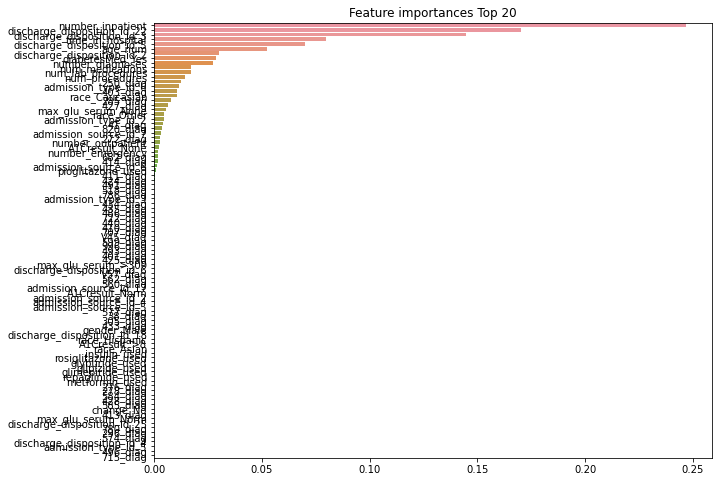

In [232]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

In [235]:
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances 

,importance
number_inpatient,0.246580
discharge_disposition_id_22,0.170400
discharge_disposition_id_3,0.144497
time_in_hospital,0.079862
discharge_disposition_id_5,0.070123
...,...
276_diag,0.000000
metformin_used,0.000000
repaglinide_used,0.000000
glimepiride_used,0.000000


In [243]:
feature_importances

,importance
number_inpatient,0.246580
discharge_disposition_id_22,0.170400
discharge_disposition_id_3,0.144497
time_in_hospital,0.079862
discharge_disposition_id_5,0.070123
age_num,0.052518
discharge_disposition_id_2,0.030266
diabetesMed_Yes,0.028828
number_diagnoses,0.027366
num_medications,0.017248


In [99]:
### TOP 43 Feautres

In [188]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'age_num',
       'discharge_disposition_id_3', 'number_diagnoses',
       'discharge_disposition_id_5', 'num_procedures', 'number_emergency',
       '786_diag', '434_diag', '428_diag', 'number_outpatient',
       'diabetesMed_Yes', '403_diag', 'discharge_disposition_id_2', '401_diag',
       'insulin_used', 'admission_source_id_7', '250_diag', 'race_Caucasian',
       'gender_Male', 'change_No', '414_diag', 'admission_type_id_3',
       'glipizide_used', 'discharge_disposition_id_6', '820_diag',
       'metformin_used', '707_diag', 'admission_type_id_2', 'A1Cresult_None',
       'admission_type_id_6', '276_diag', '440_diag', 'admission_type_id_5',
       'glyburide_used', 'max_glu_serum_None', '427_diag', 'A1Cresult_>8',
       '599_diag']

In [244]:
X = data[top_43_features]
y= data['readmit_30d']

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [246]:
tree = DecisionTreeClassifier(criterion='gini',
                              max_depth= 5, 
                              random_state=42,
                              class_weight='balanced')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [247]:
y_pred = tree.predict(X_test)

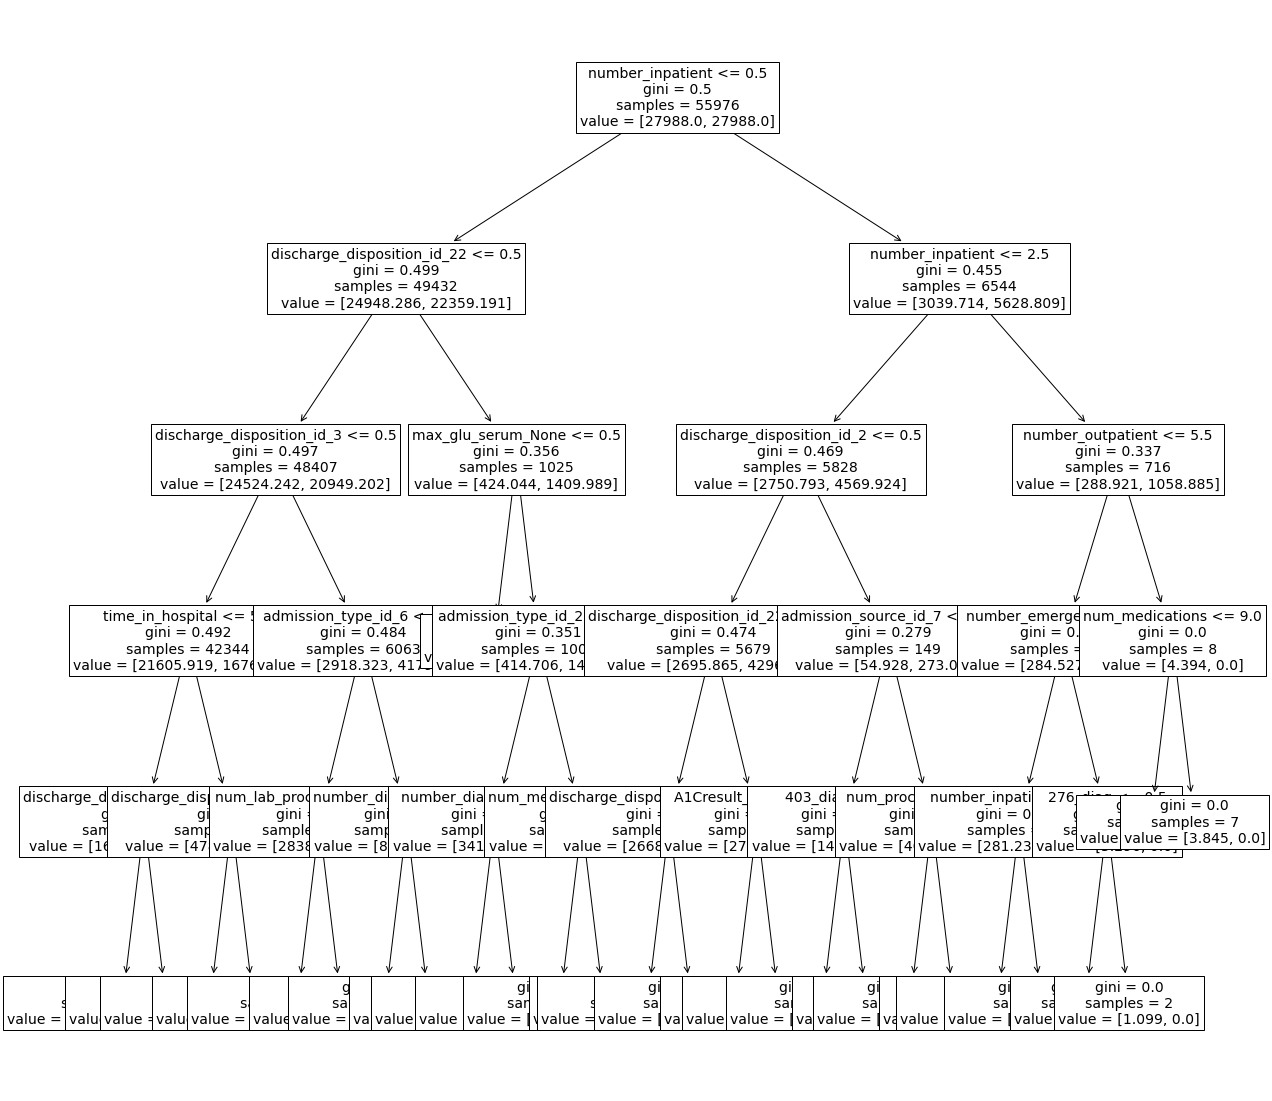

In [248]:
from sklearn.tree import plot_tree
# feature_names=X.column.tolist()
plt.figure(figsize=(20,20))
plot_tree(tree, feature_names=X_train.columns, fontsize=14)
plt.show()

In [106]:
# x = range(1,10)
# y1 = [DecisionTreeClassifier(max_depth=i, random_state=42).fit(X_train, y_train).score(X_train, y_train) for i in x]
# y2 = [DecisionTreeClassifier(max_depth=i, random_state=42).fit(X_train, y_train).score(X_test, y_test) for i in x]
# plt.plot(x,y1,label='train')
# plt.plot(x,y2,label='test')
# plt.xlabel('depth of tree')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

### Grid Search

In [250]:
# grid search class weights with decision tree for imbalance classification
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier


params = {'max_depth': [3, 5, 7,9,11],
          'min_samples_split' : [3, 5, 10, 15],
          'min_samples_leaf' : [1, 2, 3, 4, 5, 10]}

grid = GridSearchCV(estimator=tree, 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.622579 using {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 15}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.592972 (0

In [251]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.6467207766613493
0.6231590788897163


In [252]:
y_train_pred = grid_result.predict(X_train)

In [253]:
y_test_pred = grid_result.predict(X_test)

In [254]:
grid_result.score(X_train, y_train)

0.6467207766613493

In [255]:
grid_result.score(X_test, y_test)

0.6231590788897163

In [256]:
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

0.604958088637338
0.592885604923113


### 3.3.2  Confusion Matrix

In [257]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9340,3399
True[1],687,568


In [258]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))
print('ROCAUC score:',roc_auc_score(y_test, y_test_pred))

precision_score: 0.143
recall_score: 0.453
f1_score: 0.218
ROCAUC score: 0.592885604923113


In [259]:
# y_pred_p = tree.predict_proba(X_test)

In [260]:
### 3.3.3 precision recall curve

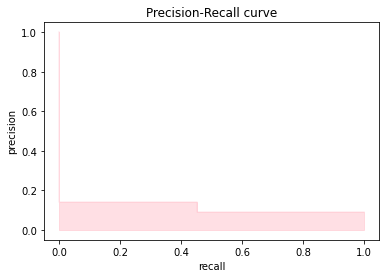

In [261]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

In [264]:
for name, value in zip(X_train.columns , grid.best_estimator_.feature_importances_): 
    print('{} : {:.5f}'.format(name, value))

number_inpatient : 0.24685
discharge_disposition_id_22 : 0.16927
time_in_hospital : 0.08101
num_lab_procedures : 0.02930
num_medications : 0.02621
age_num : 0.05114
discharge_disposition_id_3 : 0.14354
number_diagnoses : 0.02722
discharge_disposition_id_5 : 0.06966
num_procedures : 0.02219
number_emergency : 0.00195
786_diag : 0.00165
434_diag : 0.00088
428_diag : 0.00000
number_outpatient : 0.00258
diabetesMed_Yes : 0.03224
403_diag : 0.00979
discharge_disposition_id_2 : 0.03006
401_diag : 0.00092
insulin_used : 0.00000
admission_source_id_7 : 0.00303
250_diag : 0.00668
race_Caucasian : 0.01124
gender_Male : 0.00000
change_No : 0.00007
414_diag : 0.00459
admission_type_id_3 : 0.00000
glipizide_used : 0.00000
discharge_disposition_id_6 : 0.00000
820_diag : 0.00000
metformin_used : 0.00000
707_diag : 0.00000
admission_type_id_2 : 0.00362
A1Cresult_None : 0.00193
admission_type_id_6 : 0.01129
276_diag : 0.00000
440_diag : 0.00000
admission_type_id_5 : 0.00000
glyburide_used : 0.00000
max

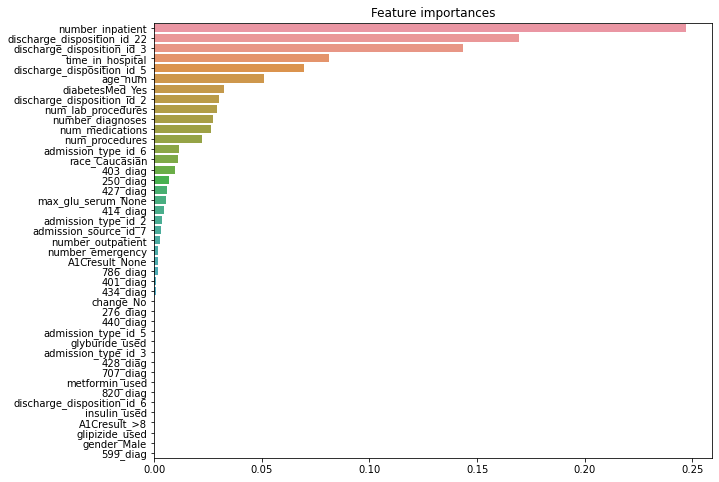

In [265]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Feature importances')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

In [266]:
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False) 

In [267]:
feature_importances 

,importance
number_inpatient,0.246846
discharge_disposition_id_22,0.169269
discharge_disposition_id_3,0.143538
time_in_hospital,0.081006
discharge_disposition_id_5,0.069657
age_num,0.051144
diabetesMed_Yes,0.032236
discharge_disposition_id_2,0.030065
num_lab_procedures,0.029303
number_diagnoses,0.027217


### 3.4 Random Forest

### 3.4.1 Random Forest Model fitting

In [131]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [135]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500, 
                                random_state=42,
                               class_weight = 'balanced',
                               max_depth = 5)

In [136]:
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=42)

In [137]:
y_pred = forest.predict(X_test)

### Grid Search

In [142]:
params = {'n_estimators' : [150, 200],
        'max_depth' : [5, 8, 10, 12],
        'min_samples_split' : [5, 8, 10, 15],
        'min_samples_leaf' : [1, 2, 5]}
grid = GridSearchCV(estimator=forest, 
                    param_grid=params, 
                    n_jobs=1, 
                    cv= 5, 
                    scoring='roc_auc',
                    verbose = 1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed: 76.9min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=5, n_estimators=500,
                                              random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [5, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 5, 1],
                         'min_samples_split': [5, 8, 10, 15],
                         'n_estimators': [150, 200]},
             scoring='roc_auc', verbose=1)

In [143]:
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'n_estimators': 200}

In [144]:
y_train_pred = grid.predict(X_train)

In [145]:
y_test_pred = grid.predict(X_test)

In [146]:
roc_auc_score(y_test, y_pred)

0.604264877846335

In [147]:
print(grid.score(X_train, y_train)) 
print(grid.score(X_test, y_test)) 

0.7326557998986661
0.64626361498038


In [148]:
roc_auc_score(y_train, y_train_pred)

0.665242872875226

In [149]:
roc_auc_score(y_test, y_test_pred)

0.600734326216603

### confusion Matrix

In [150]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9205,3534
True[1],654,601


In [151]:
print('accuracy_score: %.3f' % accuracy_score(y_test, y_test_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))

accuracy_score: 0.701
precision_score: 0.145
recall_score: 0.479
f1_score: 0.223


### precision recall curve

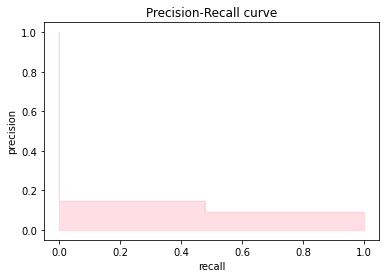

In [152]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### Fearure importance

In [ ]:
grid.best_estimator_.feature_importances_

In [ ]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Feature importances')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

 1) number_inpatient               0.167732
 2) discharge_disposition_id_22    0.118962
 3) time_in_hospital               0.093825
 4) discharge_disposition_id_3     0.093319
 5) age_num                        0.065167
 6) num_medications                0.050698
 7) number_diagnoses               0.047308
 8) discharge_disposition_id_5     0.033021
 9) num_lab_procedures             0.029925
10) 434_diag                       0.025452
11) 786_diag                       0.025326
12) number_emergency               0.019162
13) 403_diag                       0.018799
14) diabetesMed_Yes                0.014537
15) 428_diag                       0.014057
16) 401_diag                       0.013323
17) discharge_disposition_id_2     0.011040
18) num_procedures                 0.007581
19) number_outpatient              0.007269
20) 820_diag                       0.006906
21) insulin_used                   0.006635
22) 707_diag                       0.006370
23) 440_diag                    

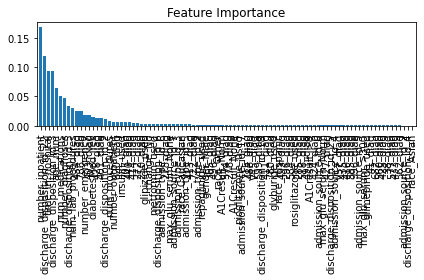

In [153]:
feat_labels = X_train.columns

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

 1) number_inpatient               0.167732
 2) discharge_disposition_id_22    0.118962
 3) time_in_hospital               0.093825
 4) discharge_disposition_id_3     0.093319
 5) age_num                        0.065167
 6) num_medications                0.050698
 7) number_diagnoses               0.047308
 8) discharge_disposition_id_5     0.033021
 9) num_lab_procedures             0.029925
10) 434_diag                       0.025452
11) 786_diag                       0.025326
12) number_emergency               0.019162
13) 403_diag                       0.018799
14) diabetesMed_Yes                0.014537
15) 428_diag                       0.014057
16) 401_diag                       0.013323
17) discharge_disposition_id_2     0.011040
18) num_procedures                 0.007581
19) number_outpatient              0.007269
20) 820_diag                       0.006906
21) insulin_used                   0.006635
22) 707_diag                       0.006370
23) 440_diag                    

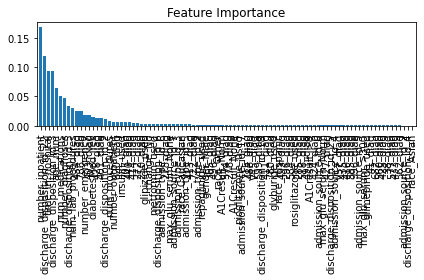

In [154]:
feat_labels = X_train.columns

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [155]:
import pandas as pd
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
number_inpatient,0.167732
discharge_disposition_id_22,0.118962
time_in_hospital,0.093825
discharge_disposition_id_3,0.093319
age_num,0.065167
...,...
433_diag,0.000580
562_diag,0.000538
admission_source_id_2,0.000472
discharge_disposition_id_4,0.000430


In [156]:
feature_importances.index

Index(['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'discharge_disposition_id_5', 'num_lab_procedures',
       '434_diag', '786_diag', 'number_emergency', '403_diag',
       'diabetesMed_Yes', '428_diag', '401_diag', 'discharge_disposition_id_2',
       'num_procedures', 'number_outpatient', '820_diag', 'insulin_used',
       '707_diag', '440_diag', '414_diag', '272_diag', '250_diag',
       'glipizide_used', 'change_No', 'metformin_used',
       'discharge_disposition_id_6', 'admission_type_id_6', '278_diag',
       'max_glu_serum_None', 'admission_source_id_7', 'admission_type_id_3',
       'race_Caucasian', 'admission_type_id_5', '413_diag', '722_diag',
       'admission_type_id_2', 'repaglinide_used', 'gender_Male', '305_diag',
       '496_diag', 'race_Other', 'A1Cresult_Norm', '574_diag', '276_diag',
       'A1Cresult_None', 'pioglitazone_used', 'admission_source

In [96]:
#feature_importances[feature_importances.importance >= np.median(feature_importances.importance)]#.index

### RandomForest : class weight  = "balanced_subsample"

In [158]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [161]:
from sklearn.ensemble import RandomForestClassifier
forest_sub = RandomForestClassifier(n_estimators= 200,
                                random_state=42,
                               class_weight = 'balanced_subsample',
                               max_depth = 5)

In [162]:
forest_sub.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_estimators=200, random_state=42)

In [163]:
y_pred = forest_sub.predict(X_test)

#### GridSearch

In [166]:
params = {'n_estimators' : [120, 150, 200],
        'max_depth' : [8, 10, 12],
        'min_samples_split' : [8, 10, 12, 15],
        'min_samples_leaf' : [2, 4, 5, 7]}
grid = GridSearchCV(estimator=forest_sub, 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

In [167]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 200}
0.6457771474200921


In [168]:
roc_auc_score(y_test, y_pred)

0.6074462179541509

In [169]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.7348095490568821
0.6432666382902335


In [170]:
y_pred_train = grid_result.predict(X_train)

In [171]:
y_pred_test = grid_result.predict(X_test)

In [173]:
print('auc_roc')
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

auc_roc
0.665242872875226
0.600734326216603


### Confusion Matrix

In [174]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9205,3534
True[1],654,601


In [184]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))

precision_score: 0.145
recall_score: 0.479
f1_score: 0.223


### precision recall curve

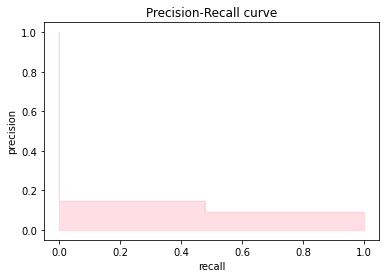

In [176]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

In [108]:
import pandas as pd
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances 

,importance
number_inpatient,0.169334
discharge_disposition_id_22,0.120738
time_in_hospital,0.096905
discharge_disposition_id_3,0.082064
age_num,0.080120
...,...
admission_source_id_2,0.000482
race_Asian,0.000430
560_diag,0.000428
discharge_disposition_id_4,0.000380


In [ ]:
grid.best_estimator_.feature_importances_

In [109]:
feature_importances.index

Index(['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'num_lab_procedures', 'discharge_disposition_id_5',
       '434_diag', '786_diag', 'diabetesMed_Yes', '401_diag', '403_diag',
       'number_emergency', 'discharge_disposition_id_2', '428_diag',
       '440_diag', '707_diag', 'num_procedures', 'insulin_used', '272_diag',
       'number_outpatient', 'admission_type_id_3', '820_diag', '250_diag',
       '414_diag', '278_diag', 'discharge_disposition_id_6',
       'admission_source_id_7', 'admission_type_id_6', '305_diag',
       'race_Caucasian', 'metformin_used', 'change_No', 'gender_Male',
       'glipizide_used', 'race_Other', 'admission_type_id_5', 'A1Cresult_>8',
       '493_diag', 'pioglitazone_used', '574_diag', '486_diag',
       'admission_type_id_2', 'V57_diag', '276_diag', '496_diag',
       'A1Cresult_None', 'admission_source_id_17', '410_diag',
       'rep

In [110]:
feature_importances[feature_importances.importance >= np.median(feature_importances.importance)]#.index

,importance
number_inpatient,0.169334
discharge_disposition_id_22,0.120738
time_in_hospital,0.096905
discharge_disposition_id_3,0.082064
age_num,0.080120
num_medications,0.047568
number_diagnoses,0.046552
num_lab_procedures,0.037008
discharge_disposition_id_5,0.036243
434_diag,0.025077


In [186]:
feature_importances.index.to_list

<bound method IndexOpsMixin.tolist of Index(['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'age_num',
       'discharge_disposition_id_3', 'number_diagnoses',
       'discharge_disposition_id_5', 'num_procedures', 'number_emergency',
       '786_diag', '434_diag', '428_diag', 'number_outpatient',
       'diabetesMed_Yes', '403_diag', 'discharge_disposition_id_2', '401_diag',
       'insulin_used', 'admission_source_id_7', '250_diag', 'race_Caucasian',
       'gender_Male', 'change_No', '414_diag', 'admission_type_id_3',
       'glipizide_used', 'discharge_disposition_id_6', '820_diag',
       'metformin_used', '707_diag', 'admission_type_id_2', 'A1Cresult_None',
       'admission_type_id_6', '276_diag', '440_diag', 'admission_type_id_5',
       'glyburide_used', 'max_glu_serum_None', '427_diag', 'A1Cresult_>8',
       '599_diag', 'admission_source_id_17', 'pioglitazone_used', '486_diag',
       '272_diag', '496_di

In [179]:
grid.best_estimator_.feature_importances_

array([0.07238231, 0.0590643 , 0.02222239, 0.05795885, 0.01422246,
       0.02058832, 0.10644167, 0.04524176, 0.05733898, 0.00102768,
       0.00132343, 0.00156529, 0.01389038, 0.00719523, 0.00190997,
       0.01125962, 0.00464067, 0.00235725, 0.00106463, 0.00247086,
       0.00277817, 0.0184686 , 0.00284564, 0.01551824, 0.00433682,
       0.00252821, 0.00506491, 0.00320165, 0.00700626, 0.00123378,
       0.00237702, 0.0020672 , 0.00115488, 0.00397164, 0.0016269 ,
       0.00872088, 0.00220226, 0.00226121, 0.00354351, 0.00176203,
       0.00358535, 0.00483042, 0.00378449, 0.00774218, 0.0031219 ,
       0.00294511, 0.00151092, 0.00276158, 0.00433011, 0.01512515,
       0.00325596, 0.0036045 , 0.00293943, 0.00549086, 0.00711019,
       0.00199243, 0.00304143, 0.00728908, 0.00496946, 0.00434435,
       0.00352034, 0.01015338, 0.00092001, 0.00866561, 0.00283541,
       0.00254252, 0.00832786, 0.00693803, 0.00731099, 0.0049835 ,
       0.00639751, 0.00360068, 0.01153975, 0.0747686 , 0.00168

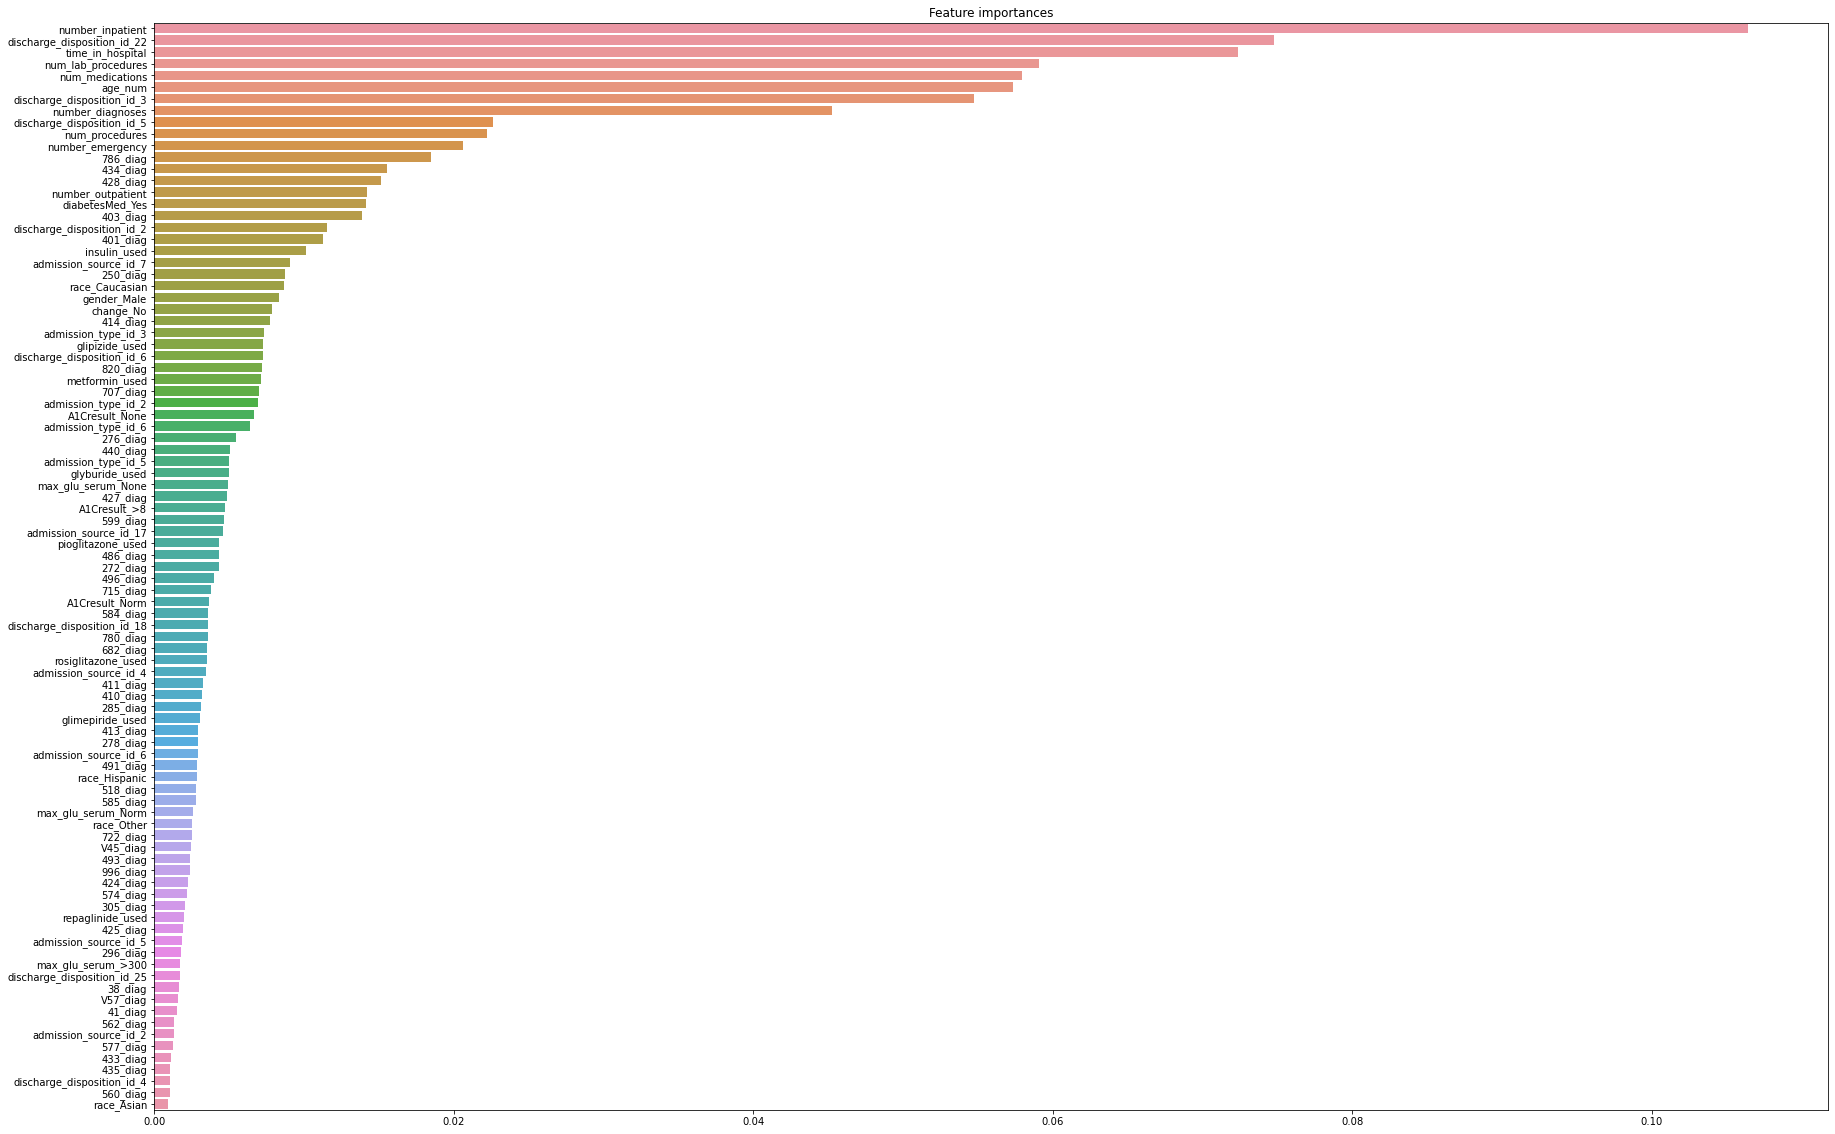

In [182]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(30,20))
plt.title('Feature importances')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

In [180]:
import pandas as pd
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances 

,importance
number_inpatient,0.106442
discharge_disposition_id_22,0.074769
time_in_hospital,0.072382
num_lab_procedures,0.059064
num_medications,0.057959
...,...
433_diag,0.001155
435_diag,0.001065
discharge_disposition_id_4,0.001045
560_diag,0.001028


In [183]:
feature_importances[feature_importances.importance >= np.median(feature_importances.importance)]#.index

,importance
number_inpatient,0.106442
discharge_disposition_id_22,0.074769
time_in_hospital,0.072382
num_lab_procedures,0.059064
num_medications,0.057959
age_num,0.057339
discharge_disposition_id_3,0.054732
number_diagnoses,0.045242
discharge_disposition_id_5,0.022642
num_procedures,0.022222


In [187]:
feature_importances[feature_importances.importance >= np.median(feature_importances.importance)].index

Index(['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'age_num',
       'discharge_disposition_id_3', 'number_diagnoses',
       'discharge_disposition_id_5', 'num_procedures', 'number_emergency',
       '786_diag', '434_diag', '428_diag', 'number_outpatient',
       'diabetesMed_Yes', '403_diag', 'discharge_disposition_id_2', '401_diag',
       'insulin_used', 'admission_source_id_7', '250_diag', 'race_Caucasian',
       'gender_Male', 'change_No', '414_diag', 'admission_type_id_3',
       'glipizide_used', 'discharge_disposition_id_6', '820_diag',
       'metformin_used', '707_diag', 'admission_type_id_2', 'A1Cresult_None',
       'admission_type_id_6', '276_diag', '440_diag', 'admission_type_id_5',
       'glyburide_used', 'max_glu_serum_None', '427_diag', 'A1Cresult_>8',
       '599_diag', 'admission_source_id_17', 'pioglitazone_used', '486_diag',
       '272_diag'],
      dtype='object')

In [ ]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'age_num',
       'discharge_disposition_id_3', 'number_diagnoses',
       'discharge_disposition_id_5', 'num_procedures', 'number_emergency',
       '786_diag', '434_diag', '428_diag', 'number_outpatient',
       'diabetesMed_Yes', '403_diag', 'discharge_disposition_id_2', '401_diag',
       'insulin_used', 'admission_source_id_7', '250_diag', 'race_Caucasian',
       'gender_Male', 'change_No', '414_diag', 'admission_type_id_3',
       'glipizide_used', 'discharge_disposition_id_6', '820_diag',
       'metformin_used', '707_diag', 'admission_type_id_2', 'A1Cresult_None',
       'admission_type_id_6', '276_diag', '440_diag', 'admission_type_id_5',
       'glyburide_used', 'max_glu_serum_None', '427_diag', 'A1Cresult_>8',
       '599_diag']

### 3.5 Gradient Boosting

In [ ]:
# Boosting model has same problem..High training accuracy, but low tests accuracy.
# It seems overfitting problem

### Train, Test split

In [112]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'discharge_disposition_id_5', 'num_lab_procedures',
       '434_diag', '786_diag', '403_diag', 'diabetesMed_Yes',
       'number_emergency', '401_diag', 'discharge_disposition_id_2',
       '428_diag', 'insulin_used', 'num_procedures', '440_diag', '707_diag',
       '272_diag', 'number_outpatient', '820_diag', 'admission_type_id_3',
       '278_diag', 'discharge_disposition_id_6', 'change_No', '414_diag',
       'admission_source_id_7', 'race_Other', 'admission_type_id_6',
       '250_diag', '305_diag', 'metformin_used', 'gender_Male', '722_diag',
       'race_Caucasian', 'glipizide_used', 'admission_type_id_5',
       'A1Cresult_None', '574_diag', 'pioglitazone_used']

In [113]:
X = data[top_43_features]
y= data['readmit_30d']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [167]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators = 100, random_state=42,learning_rate=1.0 )
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [168]:
y_pred = gbm.predict(X_test)

In [170]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12646,93
True[1],1219,36


In [252]:
params = {'n_estimators':[100, 150, 200], 'learning_rate' : [0.1, 0.5, 0.01]}
grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',
                    verbose = 1)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.4min finished


In [120]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12646,93
True[1],1219,36


In [121]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


precision_score: 0.279
recall_score: 0.029
f1_score: 0.052


In [118]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 0.1, 'n_estimators': 100}
0.6492982818955364


In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

In [119]:
roc_auc_score(y_test, y_pred)

0.510692421459464

In [122]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

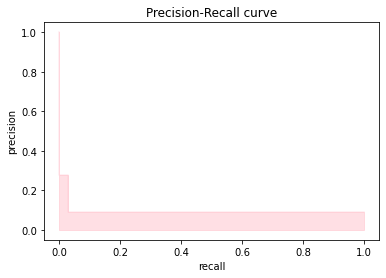

In [123]:
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');
params = {'n_estimators':[100,200]}

In [124]:
# !pip install imblearn

### SMOTE :  GradientBoostingClassifier()

In [286]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
# X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [238]:
# import imblearn
## from imblearn.under_sampling import RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy='majority')

In [287]:
from collections import Counter
from sklearn.datasets import make_classification
X = data[top_43_features]
y= data['readmit_30d']
# X, y = make_classification(weights=[0.9], flip_y=0)

In [288]:
X_train, X_test, y_train, y_test= train_test_split(X, y)

In [289]:
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [290]:
len(y_train)

52477

In [292]:
len(y_train_over)

95516

In [293]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train_over,y_train_over)
y_pred = gbm.predict(X_test)

In [294]:
y_pred = gbm.predict(X_test)

In [295]:
params = {'n_estimators':[100,120, 150,180, 200], 'learning_rate' : [0.1, 0.5, 1.0, 1.5]}
grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',
                   verbose = 1)
grid_result = grid.fit(X_train_over, y_train_over)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.5min finished


In [296]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 0.5, 'n_estimators': 200}
0.9170520678522646


In [298]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [299]:
print(grid_result.score(X_train_over, y_train_over)) 
print(grid_result.score(X_test, y_test)) 

0.9306736533606945
0.5293632709583582


In [300]:
roc_auc_score(y_test, y_pred)

0.4983430157737246

### SMOTE :  lightgbm.LGBMClassifier

In [332]:
import lightgbm

In [333]:
smote = SMOTE(random_state=0)
X = data[top_43_features]
y= data['readmit_30d']
X_train, X_test, y_train, y_test= train_test_split(X, y)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [334]:
print(len(y_train))
print(len(y_train_over))

52477
95540


In [335]:
lgb = lightgbm.LGBMClassifier()
lgb.fit(X_train_over,y_train_over)
y_pred = gbm.predict(X_test)

In [336]:
y_pred = gbm.predict(X_test)

In [337]:
params = {'num_leaves' : [5,10,15], 'learning_rate' : [0.01, 0.1, 0.5], 'max_depth' : [-1,5,10] ,'lambda_l1':[0.1,0.3,0.7]}
grid = GridSearchCV(estimator=lightgbm.LGBMClassifier(random_state=42, num_boost_round =3000, early_stoping_rounds = 1000, verbose_eval = 100), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train_over, y_train_over)

In [338]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'lambda_l1': 0.1, 'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 15}
0.9555763515820536


In [339]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],13315,2608
True[1],1292,278


In [340]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

precision_score: 0.096
recall_score: 0.177
f1_score: 0.125


In [341]:
roc_auc_score(y_test, y_pred)

0.5066409164166245

In [342]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [343]:
print(grid_result.score(X_train_over, y_train_over)) 
print(grid_result.score(X_test, y_test)) 

0.9999691297823912
0.5406380867158871


In [278]:
# !pip3 install xgboost

In [279]:
import xgboost 

###  XGBClassifier

In [312]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[09:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [329]:
y_pred = gbm.predict(X_test)

In [316]:
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

[09:02:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [318]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],13204,2691
True[1],1331,267


In [319]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

precision_score: 0.090
recall_score: 0.167
f1_score: 0.117


In [326]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'scale_pos_weight': 1}
0.6234088191781396


In [330]:
y_pred = gbm.predict(X_test)

In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

In [322]:
roc_auc_score(y_test, y_pred)

0.49889266663543336

In [327]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [328]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.8435513768622764
0.6177182983920211


In [ ]:
### SMOTE : XGBClassifier

In [346]:
smote = SMOTE(random_state=0)
X = data[top_43_features]
y= data['readmit_30d']
X_train, X_test, y_train, y_test= train_test_split(X, y)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [347]:
print(len(y_train))
print(len(y_train_over))

52477
95382


In [350]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_over, y_train_over)

[11:00:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [351]:
params = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
grid_result = grid.fit(X_train_over, y_train_over)

[11:03:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [352]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'scale_pos_weight': 1}
0.9230863433515762


In [353]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],13395,2607
True[1],1212,279


In [354]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'scale_pos_weight': 1}
0.9230863433515762


In [355]:
y_pred = gbm.predict(X_test)

In [356]:
roc_auc_score(y_test, y_pred)

0.5112195482606928

In [357]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [358]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.7010062877524447
0.5432269490793865


In [359]:
### SMOTE :  lightgbm.LGBMClassifier

In [360]:
import lightgbm

In [ ]:
smote = SMOTE(random_state=0)
X = data[top_43_features]
y= data['readmit_30d']
X_train, X_test, y_train, y_test= train_test_split(X, y)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [ ]:
print(len(y_train))
print(len(y_train_over))

In [ ]:
lgb = lightgbm.LGBMClassifier()
lgb.fit(X_train_over,y_train_over)
y_pred = gbm.predict(X_test)

In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
params = {'num_leaves' : [5,10,15], 'learning_rate' : [0.01, 0.1, 0.5], 'max_depth' : [-1,5,10] ,'lambda_l1':[0.1,0.3,0.7]}
grid = GridSearchCV(estimator=lightgbm.LGBMClassifier(random_state=42, num_boost_round =3000, early_stoping_rounds = 1000, verbose_eval = 100), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train_over, y_train_over)

In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)

In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 